In [34]:
import json 
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import io
import os 
import torch.nn as nn 
import torch 
import seaborn as sns
import numpy as np
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from scipy import stats
from sklearn.metrics import f1_score
from numpy import savetxt

# Data preparation

## TRAIN 1 - 2 CSV

In [2]:
train_1 = pd.read_csv('train1.csv')
train_2 = pd.read_csv('train2.csv', sep='delimiter', header=None)
train_2 = train_2[0].str.split(';', expand=True)
train_2.columns = train_2.iloc[0] 
train_2 = train_2[1:]
test_x = pd.read_csv('test_x.csv')

<ipython-input-2-550e3e530c4f>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_2 = pd.read_csv('train2.csv', sep='delimiter', header=None)


## TRAIN 3, 4, 5 - JSON

In [3]:
# store the URL in url as 
# parameter for read_json
url3 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first"
  
# store the response of URL into pandas table
train_3 = pd.read_json(url3)

#sort columns by name
train_3 = train_3.reindex(sorted(train_3.columns), axis=1)

#drop unique columns to align with csvs
train_3.drop('', inplace=True, axis=1)
train_3.drop('EPRTRAnnexIMainActivityCode', inplace=True, axis=1)
train_3.drop('EPRTRSectorCode', inplace=True, axis=1)

In [4]:
# store the URL in url as 
# parameter for read_json
url4 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second"

# store the response of URL into pandas table
train_4 = pd.read_json(url4)

#sort columns by name
train_4 = train_4.reindex(sorted(train_4.columns), axis=1)

#drop unique columns to align with csvs
train_4.drop('', inplace=True, axis=1)
train_4.drop('EPRTRAnnexIMainActivityCode', inplace=True, axis=1)
train_4.drop('EPRTRSectorCode', inplace=True, axis=1)

In [5]:
# store the URL in url as 
# parameter for read_json
url5 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third"
  
# store the response of URL into pandas table
train_5 = pd.read_json(url5)

#sort columns by name
train_5 = train_5.reindex(sorted(train_5.columns), axis=1)

#drop unique columns to align with csvs
train_5.drop('', inplace=True, axis=1)
train_5.drop('EPRTRAnnexIMainActivityCode', inplace=True, axis=1)
train_5.drop('EPRTRSectorCode', inplace=True, axis=1)

## TRAIN 6 - PDFs

In [6]:
def extract_text_from_pdf(pdf_path):
    """
    This function extracts text from pdf file and return text as string.
    :param pdf_path: path to pdf file.
    :return: text string containing text of pdf.
    """
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)

    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, caching=True, check_extractable=True):
            page_interpreter.process_page(page)

        text = fake_file_handle.getvalue()

    # close open handles
    converter.close()
    fake_file_handle.close()

    if text:
        return text
    return None


In [7]:
def format_pdf(text):
    text_aux = text.split(':')
    new_input = []
    match2 = ''
    for t in text_aux:
        new_text = t
        match = [header for header in cols_translation.keys() if(header in t)]
        if len(match)!=0:
            new_text = t.replace(match[0],cols_translation[match[0]])
        else: 
            match2 = [col for col in same_cols if(col in t)]
            if len(match2)!=0:
                new_text = t.replace(match2[0], ';'+match2[0])
        new_input.append(new_text)

    new = ": ".join(new_input)
    return new

In [8]:
def text_to_dict(pdf_string):
    col_values = pdf_string.split(";")
    col_values_ = []
    for e in col_values: 
        pair = e.split(': ')
        pair[0] = '"' +pair[0] + '"'
        pair[1] = '"' +pair[1] + '"'
        fixed_pair = ": ".join(pair)
        col_values_.append(fixed_pair)

    text = "{"+",".join(col_values_)+"}"
    text = text.replace('\x0c', '')
    pdf_dict = json.loads(text)
    return pdf_dict 


In [9]:
cols_translation = {'FACILITY NAME': ';facilityName',
                   'COUNTRY': ';countryName', 'CITY_ID': ';CITY ID: ', 'SectorName': ';eprtrSectorName', 
                   'MainActivityCode':';EPRTRAnnexIMainActivityLabel', 'YEAR': ';reportingYear',
                   'emissions': ';emissions', 'CITY': ';City', 'targetRealase': ';targetRelease',
                   'METEOROLOGICAL CONDITIONS': ';', 'EPRTRSectorCode': '; EPRTRSectorCode'}
same_cols = [item for item in list(train_1.columns) if item not in list(cols_translation.values())]
numerical_cols = ["emissions", "DAY", "MONTH", "reportingYear", "max_wind_speed", "min_wind_speed", "avg_wind_speed", 
                  "max_temp", "min_temp", "avg_temp", "DAYS FOG"]

directory = "train6"
list_of_dfs = []
idx = 0
for filename in os.listdir(directory):
    pdf_path = directory+"/"+filename
    text = extract_text_from_pdf(pdf_path)
    formatted_text = format_pdf(text)
    pdf_dict = text_to_dict(formatted_text)
    df = pd.DataFrame(pdf_dict, index=[idx])
    list_of_dfs.append(df)
    idx+=1
    
train_6 = pd.concat(list_of_dfs, axis=0)


In [10]:
#sort columns by name
train_6 = train_6.reindex(sorted(train_6.columns), axis=1)

#drop unique columns to align with other dataframes
train_6.drop('REPORT CONTAMINACIÓNnº', inplace=True, axis=1)
train_6.drop('emissions', inplace=True, axis=1)
train_6.drop(' EPRTRSectorCode', inplace=True, axis=1)

#change DAYS FOG name to align with the other dataframes
train_6.rename(columns = {'DAYS FOG':'DAY WITH FOGS'}, inplace = True)

#remove notation from min_max and avg values to align with the other datasets

cols_to_change = ["max_temp", "max_wind_speed", "min_temp", "min_wind_speed", "avg_temp", "avg_wind_speed"]

def label_replace(row):
    for i in cols_to_change: 
        a = [row[i].replace(',', '.')][0]
        if 'E+15' in a:
            a = float([a.replace('E+15', '')][0])
        elif 'E+14' in a:
            a = float([a.replace('E+14', '')][0]) * 0.1
        elif 'E+16' in a:
            a = float([a.replace('E+16', '')][0]) * 10.0
        row[i] = a
    return row


train_6 = train_6.apply(lambda row: label_replace(row), axis=1)

#print head
train_6.head()

#print columns
train_6.columns

Index(['CITY ID', 'CONTINENT', 'City', 'DAY', 'DAY WITH FOGS',
       'EPRTRAnnexIMainActivityLabel', 'FacilityInspireID', 'MONTH',
       'REPORTER NAME', 'avg_temp', 'avg_wind_speed', 'countryName',
       'eprtrSectorName', 'facilityName', 'max_temp', 'max_wind_speed',
       'min_temp', 'min_wind_speed', 'pollutant', 'reportingYear',
       'targetRelease'],
      dtype='object')

## CONCATENATE 1-6

In [11]:
#concatenate train datasets into one
train = pd.concat( [train_1, train_2, train_3, train_4, train_5, train_6], axis = 0)

#Drop city column due to having too many typos and missing values,since we already have city ID 
train.drop('City', inplace=True, axis=1)
test_x.drop('City', inplace=True, axis=1)

print(train.shape)

(65710, 20)


In [12]:
print(train.columns)

Index(['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName', 'targetRelease', 'pollutant',
       'reportingYear', 'MONTH', 'DAY', 'CONTINENT', 'max_wind_speed',
       'avg_wind_speed', 'min_wind_speed', 'max_temp', 'avg_temp', 'min_temp',
       'DAY WITH FOGS', 'REPORTER NAME', 'CITY ID'],
      dtype='object')


## Clean dataset

In [13]:
train.describe()

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,targetRelease,pollutant,reportingYear,MONTH,DAY,CONTINENT,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID
count,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710,65710
unique,32,9,81,7423,9321,1,3,28,24,56,1,61923,61915,61927,61931,61926,61924,40,45065,5138
top,United Kingdom,Energy sector,Thermal power stations and other combustion in...,https://data.ied_registry.omgeving.vlaanderen....,Enel Produzione S.p.A.,AIR,Nitrogen oxides (NOX),2010,4,13,EUROPE,15.541420081620483,18.76132099596884,28.95354840561177,10.219241662229653,13.17967145167063,14.218888062873848,1,Michael Brown,cfab1ba8c67c7c838db98d666f02a132
freq,9098,24588,21527,42,234,65710,26002,3822,3991,1769,65710,5,5,5,5,5,5,13986,25,1975


In [14]:
# remove irrelevant cols 
cols_to_remove = ['CONTINENT', 'FacilityInspireID', 'facilityName', 'targetRelease', 'REPORTER NAME']
def remove_cols(data):
    df = data.drop(cols_to_remove, axis=1)
    print(type(df))
    return data.drop(cols_to_remove, axis=1)

In [15]:
#change dataframe elements type to string and lowercase to detect duplicate entries
def remove_dups(train):
    train = train.astype('str')
    for i in train.columns:
        train[i] = train[i].str.lower()
    #drop duplicate entries
    train.drop_duplicates(subset=None, keep="first", inplace=True)
    return train

In [16]:
# converting some columns to numerical labels
le = preprocessing.LabelEncoder()

In [17]:
categorical_cols = ['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel', 'CITY ID']
def transform_cols(data):
    for col in categorical_cols:
        LE = le.fit(data[col])
        #transforming to integers
        data[col]=LE.transform(data[[col]])
    return data

In [18]:
float_cols = ['avg_temp', 'avg_wind_speed', 'max_temp', 'max_wind_speed', 'min_temp', 'min_wind_speed', 'Pollutant code']
def convert_float(data):
    for col in float_cols:
        data[col] = data[col].astype(float)
    return data

In [19]:
LE = le.fit(train['pollutant'])
new_col = list(LE.transform(train[['pollutant']]))
train.insert(loc=4, column='Pollutant code', value=new_col)

C:\Users\carla\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [20]:
train_clean = remove_cols(train)
train_clean = remove_dups(train_clean)
train_clean = transform_cols(train_clean)
train_clean = convert_float(train_clean)

<class 'pandas.core.frame.DataFrame'>


In [21]:

#for i in float_cols:
    #train_clean[i] = train_clean[(np.abs(stats.zscore(train_clean[i])) < 3)]


In [22]:
float_cols = ['avg_temp', 'avg_wind_speed', 'max_temp', 'max_wind_speed', 'min_temp', 'min_wind_speed']

test_clean = remove_cols(test_x)
test_clean = remove_dups(test_clean)
test_clean = transform_cols(test_clean)
test_clean = test_clean.drop(['test_index', 'EPRTRSectorCode', 'EPRTRAnnexIMainActivityCode'], axis=1)
test_clean = convert_float(test_clean)

<class 'pandas.core.frame.DataFrame'>


In [23]:
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())


for col in float_cols:
    train_clean[col] = min_max_scaling(train_clean[col])

In [24]:
test_clean.head()

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,CITY ID
0,22,4,68,2017,8,16,14.080054,14.855940,18.474836,10.278561,11.381181,13.480752,1,2208
1,18,8,57,2008,11,22,16.052425,17.623877,22.622900,6.625910,8.840137,13.422924,0,4031
2,20,2,63,2014,9,19,13.647318,15.541979,17.818521,5.669436,8.403322,11.276388,2,2033
3,29,8,57,2011,7,17,16.336762,17.458113,19.961777,6.160560,7.571596,9.443572,2,659
4,23,2,63,2010,6,23,21.516602,20.532473,21.617137,10.964012,11.548033,12.624114,2,472


In [25]:
train_clean.head()

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,Pollutant code,pollutant,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,CITY ID
0,10,4,59,0.0,carbon dioxide (co2),2015,10,20,0.655290,9.355987e-13,0.713477,0.247340,1.416146e-12,0.145485,2,2470
1,15,4,60,2.0,nitrogen oxides (nox),2018,9,21,0.854200,1.270408e-12,0.724827,0.276729,1.583205e-12,0.181305,1,4129
2,28,8,68,1.0,methane (ch4),2019,2,4,0.550672,9.613897e-13,0.568266,0.232027,1.376900e-12,0.129288,2,1581
3,5,2,74,2.0,nitrogen oxides (nox),2012,8,6,0.512445,1.055469e-12,0.582845,0.339031,1.721497e-12,0.229707,0,1101
4,8,8,80,1.0,methane (ch4),2018,12,22,0.742563,1.325603e-12,0.717411,0.348100,1.780914e-12,0.242895,2,1402


# Data visualization

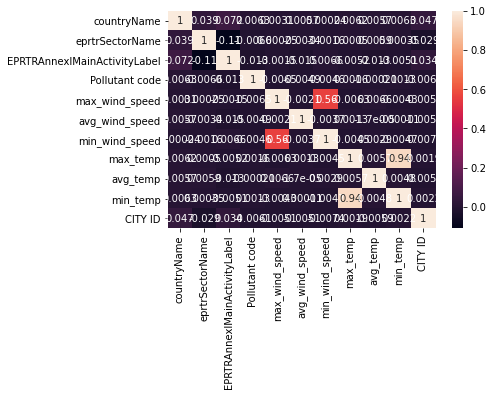

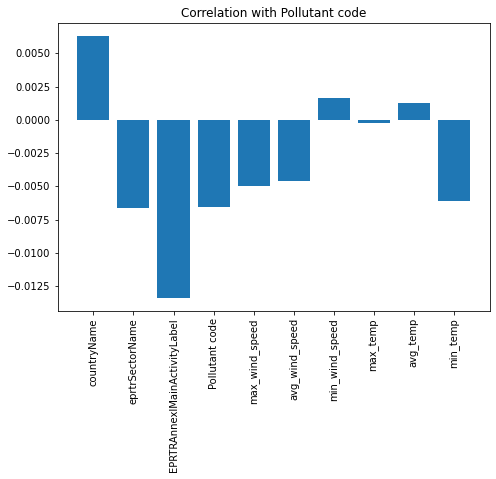

In [26]:
corrMatrix = train_clean.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

cols = list()
for col in corrMatrix:
    cols.append(col)

cols = cols[:-1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

corr_pol = corrMatrix['Pollutant code']
corr_pol = corr_pol.drop('Pollutant code')
values = corr_pol.tolist()

ax.bar(cols, values)
plt.title("Correlation with Pollutant code")
plt.xticks(rotation=90)
plt.show()

In [27]:
train_clean.drop('avg_temp', inplace=True, axis=1)
train_clean.drop('max_temp', inplace=True, axis=1)
train_clean.drop('min_wind_speed', inplace=True, axis=1)

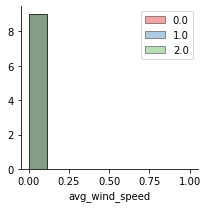

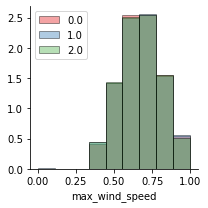

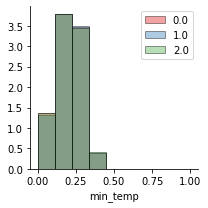

In [28]:
float_cols = ['avg_wind_speed', 'max_wind_speed', 'min_temp']

for col in float_cols:
    bins = np.linspace(train_clean[col].min(), train_clean[col].max(), 10)
    g = sns.FacetGrid(train_clean,hue='Pollutant code', palette="Set1")
    g.map(plt.hist, col, bins=bins, ec="k",  density=True,  alpha = 0.4)

    plt.legend()
    plt.show()

# Train the model

In [29]:
train_clean_ = train_clean.copy()
train_clean_x = train_clean_.drop(['pollutant', 'Pollutant code'], axis=1)
train_clean_y = train_clean_[['Pollutant code']]

In [30]:
X_train, X_test, y_train, y_test= train_test_split (train_clean_x, train_clean_y, test_size=0.20, random_state=42)

model_DT = DecisionTreeClassifier()
model_DT.fit(X_train, y_train)
y_pred_DT=model_DT.predict(X_test)

matrix_DT = confusion_matrix(y_test, y_pred_DT)
print("Confussion matrix:\n", matrix_DT)

result_DT = model_DT.score(X_test, y_test)
print("Accuracy", result_DT)

report_DT= classification_report(y_test, y_pred_DT)
print(report_DT)

Confussion matrix:
 [[2201  209 1836]
 [ 187 2573  256]
 [1814  264 2750]]
Accuracy 0.6223325062034739
              precision    recall  f1-score   support

         0.0       0.52      0.52      0.52      4246
         1.0       0.84      0.85      0.85      3016
         2.0       0.57      0.57      0.57      4828

    accuracy                           0.62     12090
   macro avg       0.65      0.65      0.65     12090
weighted avg       0.62      0.62      0.62     12090



In [31]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

y_pred_RF = RF.predict(X_test)
result_RF = RF.score(X_test, y_test)
print("Accuracy: ", result_RF)
matrix_RF = confusion_matrix(y_test, y_pred_RF)
print("Confussion matrix: \n", matrix_RF)
report_RF = classification_report(y_test, y_pred_RF)
print(report_RF)



<ipython-input-31-484d26dede2a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, y_train)


Accuracy:  0.6437551695616212
Confussion matrix: 
 [[2252   92 1902]
 [ 189 2579  248]
 [1747  129 2952]]
              precision    recall  f1-score   support

         0.0       0.54      0.53      0.53      4246
         1.0       0.92      0.86      0.89      3016
         2.0       0.58      0.61      0.59      4828

    accuracy                           0.64     12090
   macro avg       0.68      0.67      0.67     12090
weighted avg       0.65      0.64      0.65     12090



In [37]:
model = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
model.fit(X_train, y_train)

#Predict Output
y_pred_KNN = model.predict(X_test) # 0:Overcast, 2:Mild
matrix_DT = confusion_matrix(y_test, y_pred_KNN)
print("Confussion matrix:\n", matrix_DT)

result_DT = model_DT.score(X_test, y_test)
print("Accuracy", result_DT)
report_RF = classification_report(y_test, y_pred_RF)
print(report_RF)

savetxt('predictions.csv', y_pred_KNN, delimiter=',')

lists = y_pred_KNN.tolist()
json_str = json.dumps(lists)

jsonFile = open("predictions.json", "w")
jsonFile.write(json_str)
jsonFile.close()


<ipython-input-37-734b809e3889>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(X_train, y_train)


Confussion matrix:
 [[2221  185 1840]
 [ 422 2285  309]
 [2034  269 2525]]
Accuracy 0.6223325062034739
              precision    recall  f1-score   support

         0.0       0.54      0.53      0.53      4246
         1.0       0.92      0.86      0.89      3016
         2.0       0.58      0.61      0.59      4828

    accuracy                           0.64     12090
   macro avg       0.68      0.67      0.67     12090
weighted avg       0.65      0.64      0.65     12090



In [38]:
model_GBT = GradientBoostingClassifier()
model_GBT.fit(X_train, y_train)
y_pred_GBT = model_GBT.predict(X_test)

result_GBT = model_GBT.score(X_test, y_test)
print("Accuracy:", result_GBT)
matrix_GBT = confusion_matrix(y_test, y_pred_GBT)
print("Confusion matrix: \n", matrix_GBT)
report_RF = classification_report(y_test, y_pred_RF)
print(report_RF)

C:\Users\carla\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 0.6177005789909016
Confusion matrix: 
 [[1831   64 2351]
 [ 146 2480  390]
 [1570  101 3157]]
              precision    recall  f1-score   support

         0.0       0.54      0.53      0.53      4246
         1.0       0.92      0.86      0.89      3016
         2.0       0.58      0.61      0.59      4828

    accuracy                           0.64     12090
   macro avg       0.68      0.67      0.67     12090
weighted avg       0.65      0.64      0.65     12090



### Trying with deep net

In [39]:
class MLP_PyTorch(nn.Module):
    def __init__(self,inputNode=11,hiddenNode = 3, outputNode=1):   
        super(MLP_PyTorch, self).__init__()     
        #Define Hyperparameters
        self.inputLayerSize = inputNode
        self.outputLayerSize = outputNode
        self.hiddenLayerSize = hiddenNode
        
        # Initialize two modules implementing the two linear layers of the MLP
        self.W1 = nn.Linear(self.inputLayerSize, self.hiddenLayerSize) 
        #self.W1.requires_grad_() 
        self.W2 = nn.Linear(self.hiddenLayerSize, self.outputLayerSize)
        #self.W2.requires_grad_()

        
        self.Softmax = nn.Softmax(dim=1) # Module implementing the sigmoid funciton
        #self.sigmoid.requires_grad_()
        self.loss = nn.CrossEntropyLoss() 

    # Define the forward pass of the module using the sub-modules declared in the initializer
    def forward(self, X):
        out = self.W1.forward(X) # First Linear Layer   
        out = self.Softmax.forward(out) # activation function
        out = self.W2.forward(out) # Second Linear Layer   
        y_hat = self.Softmax.forward(out) # final activation function
        return y_hat

In [40]:
def train_PyTorch(NN,X, y,epoch = 5000,lr = .01,optimizer = None):
    list_loss = []
    for i in range(epoch):
        # reset optimizer at each epoch
        optimizer.zero_grad()

        # Process the dataset with the forward pass
        yHat = NN.forward(X)
        
        # and compute the loss function
        loss_val = NN.loss(yHat.float(),y.float())
        # Automatically compute the gradients
        loss_val.backward()
        
        # Call the optimizer to update the paramters
        optimizer.step()
        
        # Print loss and save the value at each iteration
        if i%500 == 0 : 
            print(yHat)
            print('Loss {}={}'.format(i,loss_val)) # " Accuracy = "+str(torch_accuracy(torch_threshold(yHat, 0.5), y)))
        list_loss.append(loss_val.item())
    print('Loss {}={}'.format(i,loss_val)) #" Accuracy = "+str(torch_accuracy(torch_threshold(yHat, 0.5), y)))  
    return list_loss

In [41]:
def torch_accuracy(yhat, y):
    a = 0
    for i in range(y.size(dim=0)):
        if yhat[i] == y[i]:
            a = a + 1
            a = a/y.size(dim=0)
    return a

In [42]:
X_mat = torch.tensor(np.array(X_train.astype('f')))


In [43]:
X_train = torch.tensor(np.array(X_train.astype('f')))
y_train = torch.tensor(np.array(y_train.astype('f')))
X_test = torch.tensor(np.array(X_test.astype('f')))
y_test = torch.tensor(np.array(y_test.astype('f')))


In [44]:
print(y_train)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [2.]])


In [ ]:
# Initialize a Pytorch MLP
NN = MLP_PyTorch()

optimizer = torch.optim.SGD(NN.parameters(), lr=.01) 

#Train MLP using Pytorch:
list_loss = train_PyTorch(NN,X_train,y_train,optimizer = optimizer)
print(y_train)
# Plot the evolution of the loss function during training
plt.plot(list_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss Val')

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>)
Loss 0=-0.0
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>)
Loss 500=-0.0
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>)
Loss 1000=-0.0
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>)
Loss 1500=-0.0
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>)
Loss 2000=-0.0
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>)
Loss 2500=-0.0
